### Import basic packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import math
from numpy import random
import pandas as pd
import concurrent.futures
import time
import csv

%matplotlib inline

### set local path

In [2]:
import subprocess
import os

cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
cmd_out, cmd_err = cmd.communicate()
local_path = os.fsdecode(cmd_out).strip()

### load data

In [4]:
import csv

global gdata
global markers

start = time.perf_counter()

gdata=[]
markers = []
with open(local_path+'/trimmed_networks/mouse_brain_data_0_1_0_300.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        b = []
        for x in row:
            b.append(float(x))
        gdata.append(b)

for k in range(len(gdata)):        
    if gdata[k] == [0,0,0,0,0]:
        markers.append(k)    
    
finish = time.perf_counter()
print(f'It took {finish - start} seconds.')

It took 0.3693145720001212 seconds.


In [5]:
def get_key(my_dict, val):
    
    """
    Input: my_dict is a dictionary
           val is a value
    
    returns key of val in my_dict
    """
    
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

In [9]:
def create_graph(n,shuffling=False):
    
    """
    Input: n is a integer that specifies a starting index and an ending index in the list gdata to
          specify a list of connections to form a graph.
          kwarg shuffling sets the option of shuffling edge weights, default is False. 
    
    returns a weighted graph
    """
    
    H = nx.Graph()
    x = [item[2] for item in gdata[markers[n]+2:markers[n+1]]]
    if shuffling:
        random.shuffle(x)
        
    for k in range(markers[n]+2,markers[n+1]):
        H.add_edge(int(gdata[k][0]), int(gdata[k][1]), weight = x[k-markers[n]-2])
        
    print(len(H.nodes()))
    return H

In [7]:
def compute_min_basis(G):
    
    """
    Input: G is a networkx graph object.
    
    returns a minimal cycle basis of a weighted graph. 
    """
    
    min_basis = [sorted(c) for c in nx.minimum_cycle_basis(G)]
    for cycle in min_basis:
        if len(cycle) == 1:
            min_basis.remove(cycle)
                
    return min_basis

In [18]:
def after_cycle_basis(min_basis,H):
    
    """
    Inputs: min_basis is a list, H is a networkx graph object.
    
    returns edges of the cycles in the basis and a grouped list of edge indices, where the
    group index is the cycle index in the cycle basis list. 
    
    This extra step is required because the minimal basis computed by NetworkX does not 
    necessarily return the nodesin each cycle in the order in which they're connected, 
    meaning one cannot assume that the consecutive nodes form edges in the network graph.
    
    """
    
    ordered_cycles = []
    cycle_index = []
    i = 0
    j = -1
    for f in min_basis:
        ordered_cycles.append(list(nx.all_simple_paths(H, source=f[0], target=f[len(f)-1], cutoff = len(f)-1)))
        cycle_index.append([i,list(range(j+1,j + len(f)+1))])
        j = j + len(f)
        i = i + 1

    i = 0
    cycle_basis_edges = []
    for paths in ordered_cycles:
        if set(min_basis[i]) == set(max(paths, key=len)):
            cycle_basis_edges.append(list(zip(max(paths, key=len),\
                                              max(paths, key=len)[1:] + max(paths, key=len)[:1])))
        else:
            flag = False
                
            for path in paths:
                if set(path) ==  set(min_basis[i]):
                    flag = True
                e = [list(zip(path, path[1:] + path[:1])) \
                     for path in paths if set(path) <= (set(min_basis[i]))]
                
            l = []
            for item in e:
                for subitem in item:
                    l.append(subitem)
        
            cycle_basis_edges.append(list(set(l)))
            if flag == False:
                cycle_basis_edges[i].remove((min_basis[i][len(min_basis[i])-1], min_basis[i][0]))
            else:
                cycle_basis_edges[i].remove((min_basis[i][0], min_basis[i][len(min_basis[i])-1]))
            
                                     
        i = i + 1
        
    return [cycle_basis_edges, cycle_index]

In [19]:
def before_nesting_tree(edgelist,indices,H):
    
    """
    Inputs: list of lists, where the inner lists contain edges of cycles in the basis.
            list of lists, where inner list contains cycle index and the range of edge indices
            of edges that are incideent on that cycle. H is a networkx graph object.
            
    returns cycle-edge incidence dictionary and a dictionary of edges of multiplicity greater than one,
    where the keys are the edges and the values are a list of cycle indices incident on those edges and 
    their weights respectively.
    """
    

    E = []
    for lis in edgelist:
        for tup in lis:
            E.append(tup)

    O = {}
    weights = {}
    for item in list(set(E)):
        edge_mult = []
        if E.count(item) > 1:
            n = E.index(item)
            edge_mult.append(n)
            for k in range(E.count(item)-1):
                m = E[n+1:].index(item)
                edge_mult.append(n+m+1)
                n = n + m + 1
            
            try:
                weights[item] = list(H.edges.data())[list(H.edges).index(item)][2]['weight']
                O[item]  = edge_mult
            except ValueError as ve:
                weights[(item[1],item[0])] = \
                list(H.edges.data())[list(H.edges).index((item[1],item[0]))][2]['weight']
                O[(item[1],item[0])]  = edge_mult
            
        
    #the incidence matrix of edges and cycles

    cycle_edge_incidence = {}
    l1 = []
    for edge in list(O.keys()):
        for m in O[edge]:
            for lis in indices:
                for k in lis[1]:
                    if m == k:
                        l1.append(lis[0])
                        
        cycle_edge_incidence[edge] = l1
        l1 = []
 
    return [cycle_edge_incidence, weights]

In [20]:
def nesting_tree(CE_incidence_dict, w, basis):
    
    """
    Input: CE_incidence_dict is the cycle-edge incidence dictionary
           w is the corresponding weights dictionary
           basis is the list of cycles in a minimal cycle basis
           
    returns the nesting tree or nesting trees as S
    """
    
    cycle_edge_incidence_updated = CE_incidence_dict.copy()
    weights_updated = w.copy()
    min_basis_updated = basis.copy()
    
    characteristic_tree = []
    
    while len(weights_updated) > 0:
        merge_list = []
        for k in cycle_edge_incidence_updated[get_key(weights_updated, min(weights_updated.values()))]:
            merge_list.append([len(min_basis_updated[k]), k])

        if len(merge_list) > 1:
            
            merge_list = sorted(merge_list)[0:2]
            cycle_edge_incidence_updated.pop(get_key(weights_updated, min(weights_updated.values())))
            
            for j in range(len(cycle_edge_incidence_updated.values())):
                
                flag = False
                temp = []
                
                if merge_list[0][1] in list(cycle_edge_incidence_updated.values())[j]:
                    key = get_key(cycle_edge_incidence_updated,\
                                  list(cycle_edge_incidence_updated.values())[j])
                    temp = cycle_edge_incidence_updated[key]
                    temp.remove(merge_list[0][1])
                    temp.append(len(min_basis_updated))            
                    flag = True
                
                if merge_list[1][1] in list(cycle_edge_incidence_updated.values())[j]:
                    if flag ==  True:
                        temp.remove(merge_list[1][1])
                    else:
                        key = get_key(cycle_edge_incidence_updated,\
                                      list(cycle_edge_incidence_updated.values())[j])
                        temp = cycle_edge_incidence_updated[key]
                        temp.remove(merge_list[1][1])
                        temp.append(len(min_basis_updated))
                
                if len(temp) != 0:
                    cycle_edge_incidence_updated[key] = temp
    
            characteristic_tree.append([[merge_list[0][1], merge_list[1][1]], len(min_basis_updated)])
            t = min_basis_updated[merge_list[0][1]] + min_basis_updated[merge_list[1][1]]
            t.remove(get_key(weights_updated, min(weights_updated.values()))[0])
            t.remove(get_key(weights_updated, min(weights_updated.values()))[1])
            min_basis_updated.append(t)
            weights_updated.pop(get_key(weights_updated, min(weights_updated.values())))
        else:
            weights_updated.pop(get_key(weights_updated, min(weights_updated.values())))
    
    S = nx.Graph()
    
    for lis in characteristic_tree:
        S.add_edges_from([(lis[0][0], lis[1]), (lis[0][1], lis[1])])
            
    return S

In [21]:
def graph_analysis(n,flag=False):
    
    """
    Input: n is a integer that specifies a starting index and an ending index in the list gdata to
          specify a list of connections to form a graph.
          kwarg shuffling sets the option of shuffling edge weights, default is False. 
    
    returns trees
    """
    
    G = create_graph(n)
    basis = compute_min_basis(G)
    edgelist, indices = after_cycle_basis(basis,G)
    CE_indcidence_dict, w = before_nesting_tree(edgelist,indices,G)
    trees = nesting_tree(CE_indcidence_dict,w,basis)
    
    return trees

### submitting asynchronous parallel jobs

In [136]:
start = time.perf_counter()
trees = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(graph_analysis,range(len(markers)-3,len(markers)-2))
    
    filename = '/nesting_trees_10_11_200' + '.csv'
    with open(local_path + filename, 'a') as f:
        writer = csv.writer(f)
        for result in results:
            trees.append(result)
            writer.writerow([0,0])
            for item in list(result.edges.data()):
                writer.writerow([item[0],item[1]])

                    
finish = time.perf_counter()
print(f'It took {finish - start} seconds.')

### visualizing the characteristic tree

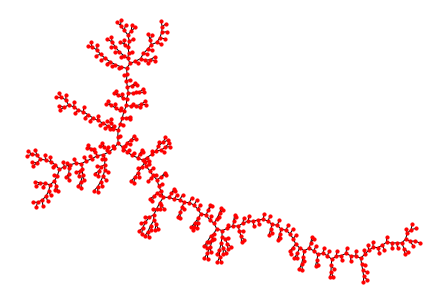

In [135]:
pos = nx.kamada_kawai_layout(trees[0].subgraph(sorted(list(nx.connected_components(trees[0])),\
                                                      key = len, reverse = True)[0]))
nx.draw(trees[0].subgraph(sorted(list(nx.connected_components(trees[0])), key = len, reverse = True)[0]),\
        pos, node_color='red', node_size=10, cmap=plt.cm.Blues, with_labels=False) 